From the last section, we see how an RNN can be used for predicting the next element in a sequence given a variable amount of previous elements. Now, we will see how well it can generalize to other *similar* sequences.

In [1]:
import sys
sys.path.append('../../..')

In [2]:
import matplotlib.pyplot as plt
import torch

from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from rnn import RNN
from CustomDL.loops.regression import train_loop, test_loop

torch.manual_seed(0)

# Setup

In [3]:
def run_epochs(
    epochs,
    model, loss_fn, optimizer,
    train_loader, test_loader,
    use_gpu: bool = False
) -> dict:
    loss = {
        'train': [],
        'eval': []
    }
    for epoch in range(1, epochs + 1):
        print(f"{epoch}/{epochs}")
        train_loss = train_loop(
            model, train_loader,
            loss_fn, optimizer, True,
            use_gpu=use_gpu
        )
        loss['train'].append(sum(train_loss) / len(train_loss))
        print(f"  Average Training Loss: {loss['train'][-1]:.6f}")

        eval_loss = test_loop(
            model, test_loader, loss_fn,
            use_gpu=use_gpu
        )
        loss['eval'].append(eval_loss)
        print(f"  Average Eval Loss: {loss['eval'][-1]:.6f}")
    
    return loss

In [4]:
class WaveDataset(Dataset):
    def __init__(self,
        wave: torch.Tensor,
        lag_duration: int
    ):
        super().__init__()
        self._wave = wave.unsqueeze(1)
        self._lag_dur = lag_duration
        self._total_seq = self._wave.shape[0] - self._lag_dur
    
    def __len__(self) -> int:
        return self._total_seq
    def __getitem__(self, index):
        if index < 0:
            raise IndexError("Only support non-negative index")
        elif index > len(self):
            raise IndexError(f"Index out of range for length {len(self)}")
        return (
            self._wave[index : index + self._lag_dur],
            self._wave[index + self._lag_dur]
        )

# Synthesizing New Sequential Data

Let's see if the model can fit to a data that is slightly different. That is, we will add tiny amount of other autocorrelation to our original data.

In [5]:
sampling_rate = 10
total_secs = 500
delta = total_secs / (sampling_rate * total_secs)

t = torch.linspace(0, total_secs, sampling_rate * total_secs)
wave = lambda t: torch.cos(2 * torch.pi * t) / (.02 * t + 2) + 0.05 * torch.cos(4 * torch.pi * t)
data = (
    wave(t) + wave(t - delta) ** 2 - torch.cos(wave(t - 2 * delta)) * torch.tanh(wave(t - 2 * delta))
    + .1 * torch.sigmoid(-1 / wave(t - 4 * delta))
)

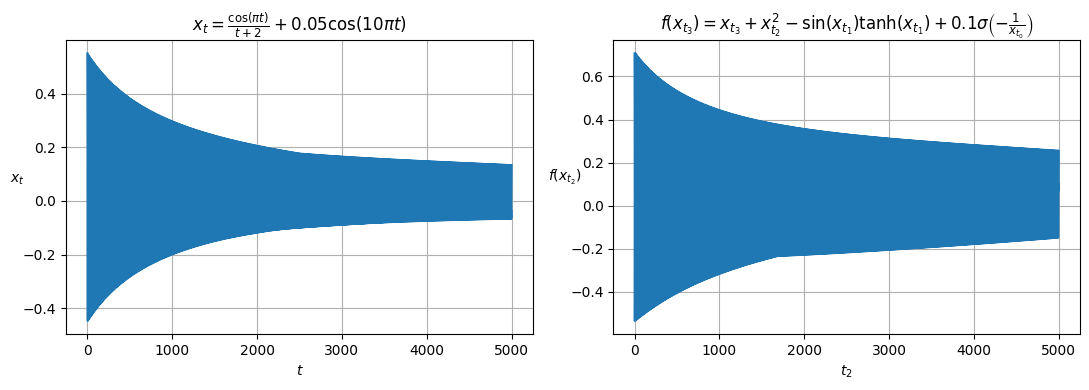

In [7]:
fig = plt.figure(figsize=(11, 4))
axes = fig.subplots(1, 2)


axes[0].set_title(r'$x_t = \frac{\cos(\pi t)}{t+2} + 0.05\cos(10\pi t)$')
axes[0].plot(wave(t))
axes[0].set_xlabel(r'$t$')
axes[0].set_ylabel(r'$x_t$', rotation=0)
axes[0].grid()


axes[1].set_title(r'$f(x_{t_3})=x_{t_3} + x_{t_2}^2 - \sin(x_{t_1})\tanh(x_{t_1}) + 0.1\sigma\left(-\frac{1}{x_{t_0}}\right)$')
axes[1].plot(data)
axes[1].set_xlabel(r'${t_2}$')
axes[1].set_ylabel(r'$f(x_{t_2})$', rotation=0)
axes[1].grid()

fig.tight_layout();

## Inference

### Loading Checkpoints

In [8]:
class RNNRegressor(nn.Module):
    def __init__(self,
        in_features: int,
        out_features: int,
        hidden_size: int,
        activation_fn: None | nn.Module=None
    ):
        super().__init__()
        self.rnn = RNN(in_features, hidden_size, activation_fn)
        self.linear = nn.Linear(hidden_size, out_features)
    
    def forward(self, seq, hidden_state=None):
        out, _ = self.rnn(seq, hidden_state)
        return self.linear(out[:, -1, :])
    
cpkt = torch.load('../output/rnn_wave.tar')

rnn_model = RNNRegressor(1, 1, 32, nn.ReLU())
rnn_model.load_state_dict(cpkt['model'])
if torch.cuda.is_available(): rnn_model.cuda()
rnn_model.eval();

In [9]:
mlp_ckpt = torch.load('../output/mlp_wave.tar')

mlp_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(5, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)
mlp_model.load_state_dict(mlp_ckpt['model'])
if torch.cuda.is_available(): mlp_model.cuda()
mlp_model.eval();

### Prediction and Visualization

In [10]:
dataset = WaveDataset(data, 5)

with torch.no_grad():
    rnn_pred = torch.concat([
        rnn_model(X.cuda() if torch.cuda.is_available() else X).cpu()
        for X, _ in tqdm(DataLoader(dataset, 32, False), desc="RNN")
    ]).squeeze()
    mlp_pred = torch.concat([
        mlp_model(X.cuda() if torch.cuda.is_available() else X).cpu()
        for X, _ in tqdm(DataLoader(dataset, 32, False), desc="MLP")
    ]).squeeze()

RNN:   0%|          | 0/157 [00:00<?, ?it/s]

MLP: 100%|██████████| 157/157 [00:00<00:00, 1912.27it/s]


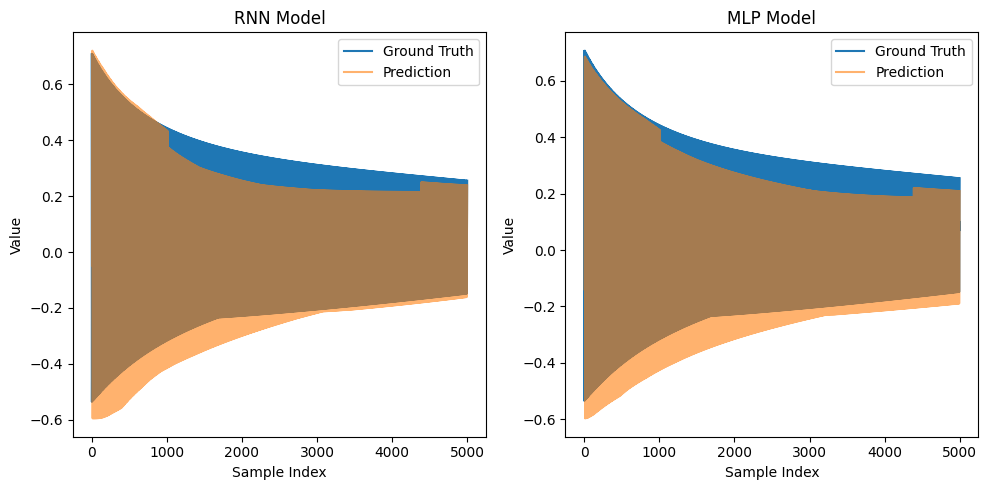

In [11]:
fig = plt.figure(figsize=(10, 5))
axes = fig.subplots(1, 2)

axes[0].plot(data, label='Ground Truth')
axes[0].plot(list(range(dataset._lag_dur, data.shape[0])), rnn_pred, label="Prediction", alpha=.6)

axes[0].set_title(f"RNN Model")
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Value')
axes[0].legend()


axes[1].plot(data, label='Ground Truth')
axes[1].plot(list(range(dataset._lag_dur, data.shape[0])), mlp_pred, label="Prediction", alpha=.6)

axes[1].set_title(f"MLP Model")
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Value')
axes[1].legend()

fig.tight_layout();

In [12]:
ground_truth = data[dataset._lag_dur:]

print(f"""RNN Average MSE Loss: {nn.functional.mse_loss(rnn_pred, ground_truth):.6f}
MLP Average MSE Loss: {nn.functional.mse_loss(mlp_pred, ground_truth):.6f}""")

RNN Average MSE Loss: 0.004402
MLP Average MSE Loss: 0.005174


## 

We see that both models can generalize to slightly new data quite well. Of course, due to the increase in autocorrelation of higher lag, the model could not predict very close to the ground truth for some samples, but still can get the general trend.

Now, let's see what happens if we fine-tune the RNN on this data with higher lag.

# Fine-tuning RNN

We will fine-tune our RNN on this data. However, this time, we will use a lag of 10.